## Environment setup

First it is mandatory to load our environment file, which holds our dataset file path.

In [1]:
from dotenv import load_dotenv
import os
load_dotenv()
dataset_path = os.getenv('TASK_DATASET_FILE_PATH')


We then import all the needed libraries, including our produced scripts:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from src.cache import cached
from src.preprocess import interesting_columns

## Preprocessing
We use `chached` from `src.cache`  to load our data, it's a commodity functions which loads or creates then caches a dataframe, saving us much needed time in loading our dataset.  
It produces a `CachedDataFrame` resource, which can be further used to manipulate these cache files.  
For our dataset, we need only the data frame, thus we just `get` it, and print some information.

In [3]:
df = cached(
    dataset_path + '.picke',
    construct = lambda : pd.read_csv(dataset_path, usecols=interesting_columns.keys()).dropna().astype(interesting_columns)
).get()
df.info( verbose=True )

<class 'pandas.core.frame.DataFrame'>
Index: 2331562 entries, 0 to 2331567
Data columns (total 13 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   scontrino_id  int64 
 1   tessera       int64 
 2   r_qta_pezzi   int64 
 3   cod_prod      int64 
 4   descr_prod    object
 5   liv1          int64 
 6   descr_liv1    object
 7   liv2          int64 
 8   descr_liv2    object
 9   liv3          int64 
 10  descr_liv3    object
 11  liv4          int64 
 12  descr_liv4    object
dtypes: int64(8), object(5)
memory usage: 249.0+ MB


We can clearly see that at least **200+ MB** have been allocated.  

The assigned tasks requires us to produce the cross table between customers and products, to further compute clusterization.  
We can compute the amount of memory used by the cross table, using `int64` as cell type:

In [4]:
number_of_cells = df['cod_prod'].nunique() * df['tessera'].nunique()
entry_size = np.int64().itemsize
print(f"The number of entries is {number_of_cells} and it requires {number_of_cells * entry_size *1e-6 :0.2f} MiB of space.")

The number of entries is 182213184 and it requires 1457.71 MiB of space.


Further considerations on the tasks are:
- Many products are bought rarely, these introduce outliers.
- Some products are too common, these would produce trivial and uninteresting results.
- Many users shops rarely, these too will introduce outliers.

We have to analyze better our dataset, then prune these unwanted features.

### Products pruning
We can plot the frequencies of products, using a logarithmic function as the orders of them vastly differ.  
The logarithmic function clearly shows where products get rarely bought, I decided to take the items with frequencies between **$10^{-3}$** and **$10^{-5}$**.

<Figure size 800x600 with 0 Axes>

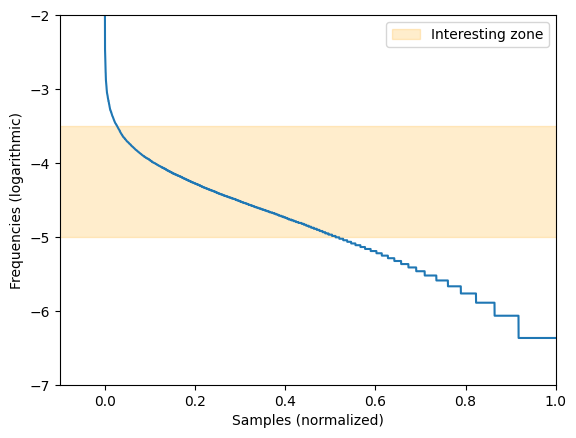

Selected 48% of products. (9412 of 19434)


In [5]:
freqs_ss = df['cod_prod'].value_counts(normalize=True)

pir = (-3.5, -5)
 
plt.figure(figsize=(8,6))

fig, ax = plt.subplots()


plt.plot( np.linspace(0,1,freqs_ss.size) ,np.log10(freqs_ss.values))

rect = patches.Rectangle(
    (-1, pir[1]), np.abs(pir[0]), 
    np.abs(pir[1]-pir[0]), 
    color='orange', alpha=0.2, label="Interesting zone"
)
plt.ylabel("Frequencies (logarithmic)")
plt.xlabel("Samples (normalized)")

plt.xlim(-.1, 1)
plt.ylim(-7, -2)
ax.add_patch(rect)
plt.legend()
plt.show()

products_ss = freqs_ss[(freqs_ss < 10**pir[0]) & (freqs_ss > 10**pir[1])]
print(f"Selected {products_ss.size/df['cod_prod'].nunique():1.0%} of products. ({products_ss.size} of {df['cod_prod'].nunique()})")

### Customers pruning
As done for products, customer frequencies in logarithmic scale are plotted as follow, I arbitrary choose a minimum support of **10**, those customers with less than **10** purchases will be marked as outliers.

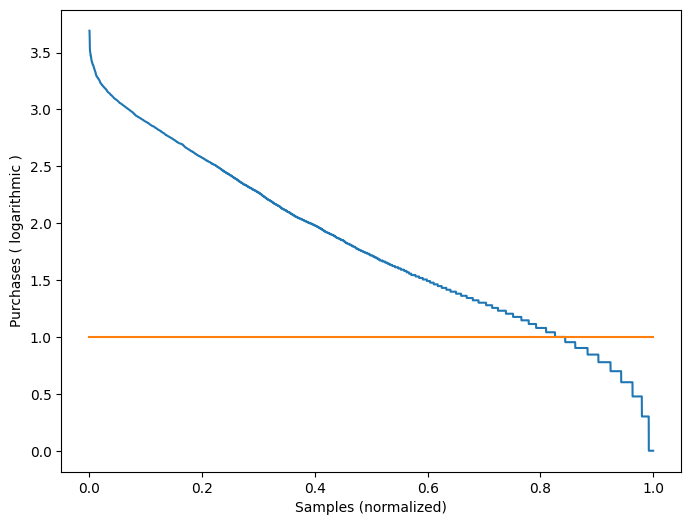

Selected 84% of customers. (7913 of 9376) 


In [6]:

freqs_ss = df['tessera'].value_counts(normalize=False)


plt.figure(figsize=(8,6))

plt.plot( np.linspace(0,1,freqs_ss.size) ,np.log10(freqs_ss.values))

plt.plot([0,1],[1,1])
plt.ylabel("Purchases ( logarithmic )")
plt.xlabel("Samples (normalized)")

plt.show()

customers_ss = freqs_ss[ (freqs_ss >= 10)]
print(f"Selected {customers_ss.size/df['tessera'].nunique():1.0%} of customers. ({customers_ss.size} of {df['tessera'].nunique()}) ")

The memory footprint of our cross table is:

In [7]:
number_of_cells = customers_ss.size * products_ss.size
entry_size = np.int32().itemsize
print(f"The number of entries is {number_of_cells} and it requires around {number_of_cells * entry_size *1e-6 :0.2f} MiB of space.")

The number of entries is 74477156 and it requires around 297.91 MiB of space.


### Creating the actual dataset
The following code selects all elements of `df` pruning out unfrequent products and occasional customers.

In [ ]:
df = df[(df['tessera'].isin(customers_ss.index)) & (df['cod_prod'].isin(products_ss.index))]
df

,scontrino_id,tessera,r_qta_pezzi,cod_prod,descr_prod,liv1,descr_liv1,liv2,descr_liv2,liv3,descr_liv3,liv4,descr_liv4
1,52597232,248425239005,1,1090781,1090781 CUKI TEGLIA EXTRA S97 8POR.X2,5,CURA CASA,504,USA E GETTA,50404,SACCHETTI/VASCHETTE ALIMENT,5040402,VASCHETTE
4,52597232,248425239005,1,3000397,3000397 *TEST P.U.GRAM.TEST N/ANT G500,1,DROGHERIA ALIMENTARE,115,PASTA,11506,PASTA ALL'UOVO,1150601,BRODI/MINESTRINE
5,52597232,248425239005,1,3000397,3000397 *TEST P.U.GRAM.TEST N/ANT G500,1,DROGHERIA ALIMENTARE,115,PASTA,11506,PASTA ALL'UOVO,1150601,BRODI/MINESTRINE
6,52597232,248425239005,1,3000226,3000226 TEST PASSATA EX.FINE MAR.ML700,1,DROGHERIA ALIMENTARE,121,DERIVATI DEL POMODORO,12104,PASSATA DI POMODORO,1210402,BOTTIGLIA/VASO
10,52597232,248425239005,1,3500912,3500912 TEST SALSA CIL.SIC.FF GR 350,1,DROGHERIA ALIMENTARE,121,DERIVATI DEL POMODORO,12104,PASSATA DI POMODORO,1210402,BOTTIGLIA/VASO
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2331562,62224004,248425244900,1,1034737,"1034737 BLD BAV BERGHOFKAESE 2,8KG",3,FRESCO,301,FORMAGGI,30115,FORMAGGI BANCO TAGLIO,3011506,EMMENTHAL E TIPO EMMENTHAL
2331563,62224004,248425244900,1,1037398,1037398 COATI PROSCIUTTO COTTO ALLEGRO,3,FRESCO,306,SALUMI,30604,SALUMI BANCO TAGLIO,3060402,PROSCIUTTO COTTO
2331565,62228225,248425239005,1,3501904,3501904 TEST ACETO BIANCO ALCOL! LT.1,1,DROGHERIA ALIMENTARE,105,"OLIO,ACETO E SUCCO DI LIMONE",10501,ACETO,1050101,STANDARD
2331566,62228225,248425239005,1,1138155,1138155 KINDER KINDERINI T20X10 G250,1,DROGHERIA ALIMENTARE,101,PRODOTTI FORNO E CEREALI,10104,BISCOTTI,1010402,FROLLINI ARRICCHITI


## Task 1: cross product matrix
We can compute the cross matrix product using DataFrame's method *pivot_table*.

In [ ]:
cross_trx = df.pivot_table(index='tessera', columns='cod_prod', values='r_qta_pezzi', aggfunc='sum', fill_value=0).astype('int32')
cross_trx.head(10)

cod_prod,1000013,1000028,1000040,1000062,1000102,1000103,1000106,1000107,1000109,1000116,...,5038749,5045768,5048769,5065294,5069947,5073248,5091106,5100931,5200276,10013191
tessera,,,,,,,,,,,,,,,,,,,,,
248400000002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
248400541208,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
248400606600,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
248401194304,0,0,0,0,0,0,4,2,0,0,...,0,0,0,0,0,0,0,0,0,0
248401302907,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
248401303607,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
248401478008,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
248401997202,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
248402057806,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Task 2: discretization between 1 and 5
We can normalize our cross table between 1 and 5, as integer, by multipying each element by 4, then dividing by the max element of the matrix, thus computing the ceiling of it and adding one.

In [ ]:
cross_trx_max = cross_trx.max().max()
cross_trx_discrete = cross_trx.apply( lambda el : np.int8(np.ceil(4*el/cross_trx_max) + 1) )
cross_trx_discrete

cod_prod,1000013,1000028,1000040,1000062,1000102,1000103,1000106,1000107,1000109,1000116,...,5038749,5045768,5048769,5065294,5069947,5073248,5091106,5100931,5200276,10013191
tessera,,,,,,,,,,,,,,,,,,,,,
248400000002,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
248400541208,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
248400606600,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
248401194304,1,1,1,1,1,1,2,2,1,1,...,1,1,1,1,1,1,1,1,1,1
248401302907,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
433000239239,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
433000239246,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
433000239253,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


## Task 3: Clustering


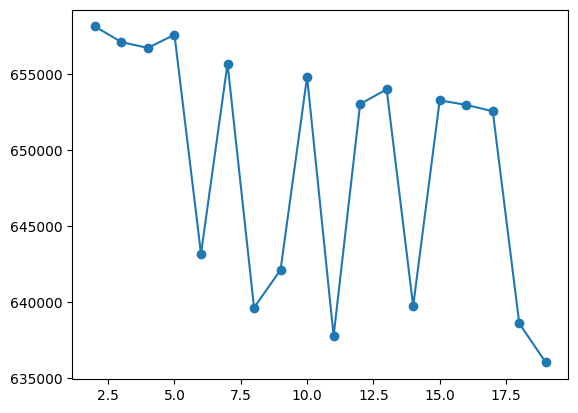

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


from sklearn.metrics import silhouette_score

indices = range(2,20)
elbow_points = [
    KMeans(n_clusters=n, init='k-means++').fit(cross_trx_discrete).inertia_ for n in indices
]

plt.plot(indices,elbow_points,'-o')
plt.show()

In [32]:
cross_trx.shape[1]
np.log(int(cross_trx.shape[1]))

9.149740749847252

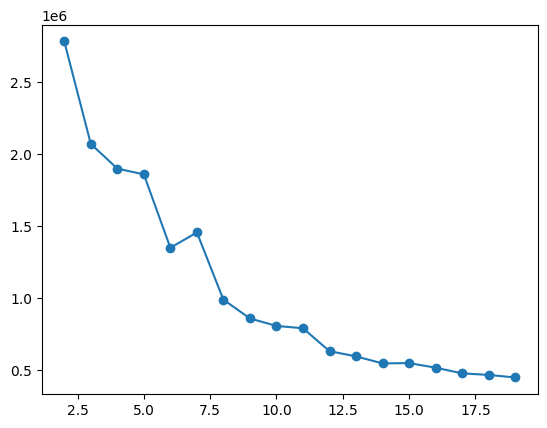

In [39]:
from sklearn.decomposition import PCA


indices = range(2,20)

data = StandardScaler().fit_transform(cross_trx)

n_components = int(np.log(data.shape[1]))
data_pca = PCA(n_components=n_components).fit_transform(data)

elbow_points = [
    KMeans(n_clusters=n, init='k-means++').fit(data_pca).inertia_ for n in indices
]

plt.plot(indices,elbow_points,'-o')
plt.show()